# Introduction

In this project, I would apply both the GP and ARIMA model to a time series and then use cross validation to compare their performance in forecasting.

* ARIMA(Auto Regressive Integrated Moving Average) forecasting is a linear equation in which the predictors consist of lags of dependent variables and lags of forecast errors.
<br><br>
* GP(Gaussian Process) regression assumes the time series to be multivariate gaussian distributed and applies the formula for conditional distribution to do interpolation and extrapolation.

#  Dataset

* The dateset used here is a time series of the popularity of a term searched in google, which has been obtained by google trends.
<br><br>
* The NBA.csv records the monthly popularity of the term "NBA" (National Basketaball Association) from Jan-2006 to Dec-2019.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
def parser(x):
    return datetime.datetime.strptime(x,"%Y-%m")
NBA = pd.read_csv('NBA.csv',header=0,parse_dates=[0],index_col=0,squeeze=True,date_parser=parser)

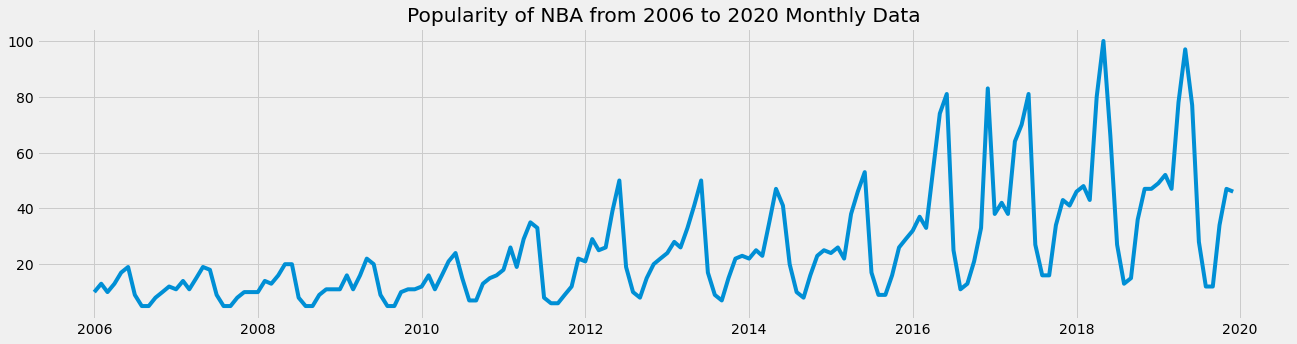

In [3]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(20,5))
plt.plot(NBA)
plt.title('Popularity of NBA from 2006 to 2020 Monthly Data')
plt.show()

# ARIMA

* Model Identification: Use ACF and PACF plots to determine the hyperparameters ARIMA(p,d,q)
* Observation: There is a repeating pattern of popularity within a year. Every year, there is a peak in the summer(May,June), sub-peak in the winter(Dec,Jan) and valley in the rest of the months. This is consistent with the yearly calendar of NBA, which indicates that the Play-offs and Conference-Finals would be held in summer; All-star games would be held in winter; Off-seasons and Regular-seasons would be held in the rest of the time.
* Decision: 
    1. Use Seasonal ARIMA, which could remove the seasonalities in the time series. The hyperparameters become SARIMA(p,d,q,s), where s is set to 12 for monthly data by experience. 
    2. Since teh SARIMA model is complex, and it is hard to eyeball the hyperparameters from ACF and PACF plots. Therefore, I used cross validation to choose the hyperparameters that yield the best performance in the testing set. Here, I split the data into 90% training and 10% testing. The result is the the best combination of hyperparamters is SARIMA(4,2,1,12)

In [4]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

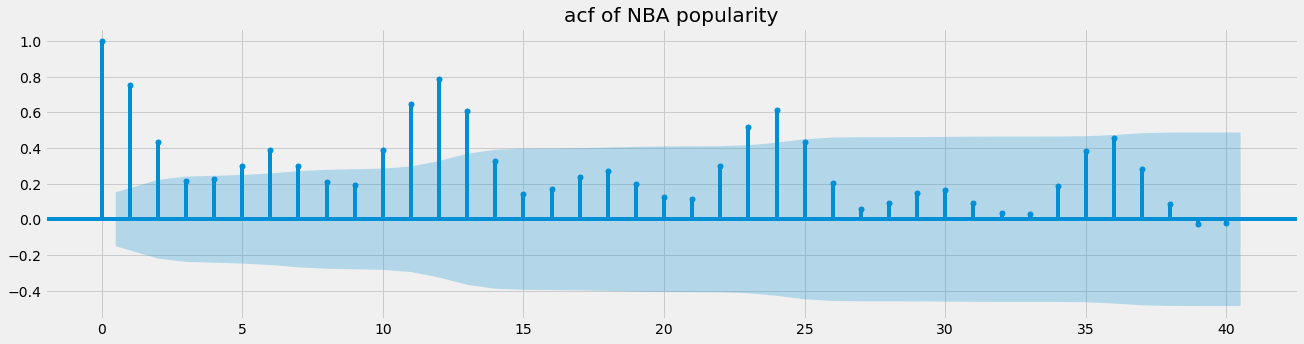

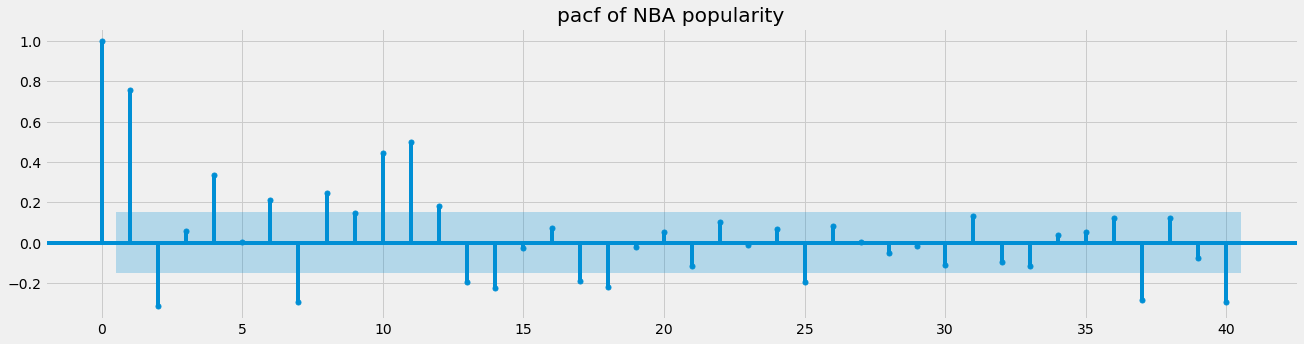

In [5]:
# plots of ACF & PACF
fig, ax1 = plt.subplots(figsize=(20,5))
fig, ax2 = plt.subplots(figsize=(20,5))
plot_acf(x=NBA,lags=40,title='acf of NBA popularity', ax=ax1)
plot_pacf(x=NBA,lags=40,title='pacf of NBA popularity', ax=ax2)
plt.show()

# ARIMA Train Test Split Forecast

In [6]:
NBA.index = NBA.index.to_period("M")

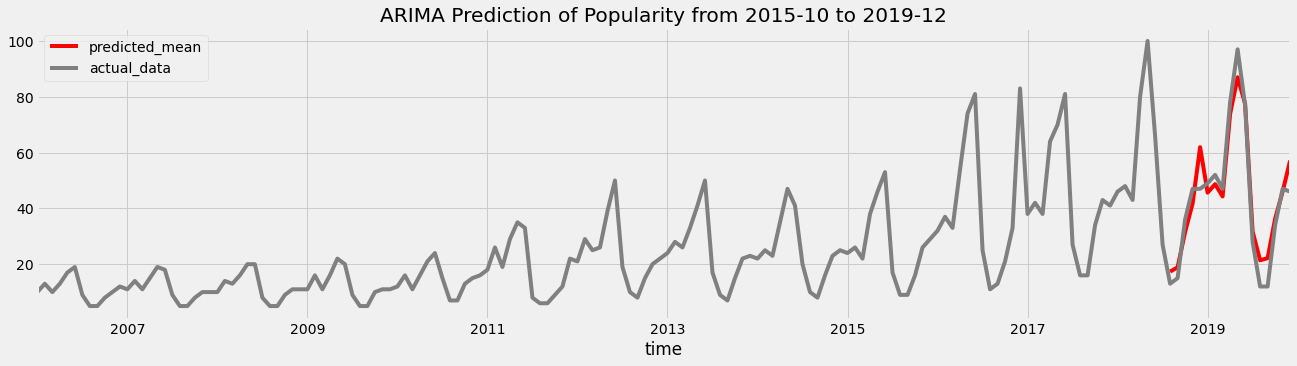

In [7]:
train_size = int(len(NBA)*0.9)
training = NBA[:train_size]
testing = NBA[train_size:]
arima = sm.tsa.statespace.SARIMAX(training, seasonal_order = (2,1,2,12),trend='c')
arima_fit = arima.fit()
predictions_arima = pd.DataFrame(arima_fit.forecast(steps = len(testing)))
predictions_arima.plot(figsize=(20,5),color='red',label = 'predicted_value')
NBA.plot(figsize=(20,5),color = 'gray',label = 'actual_data')
plt.title('ARIMA Prediction of Popularity from 2015-10 to 2019-12')
plt.legend()
plt.show()

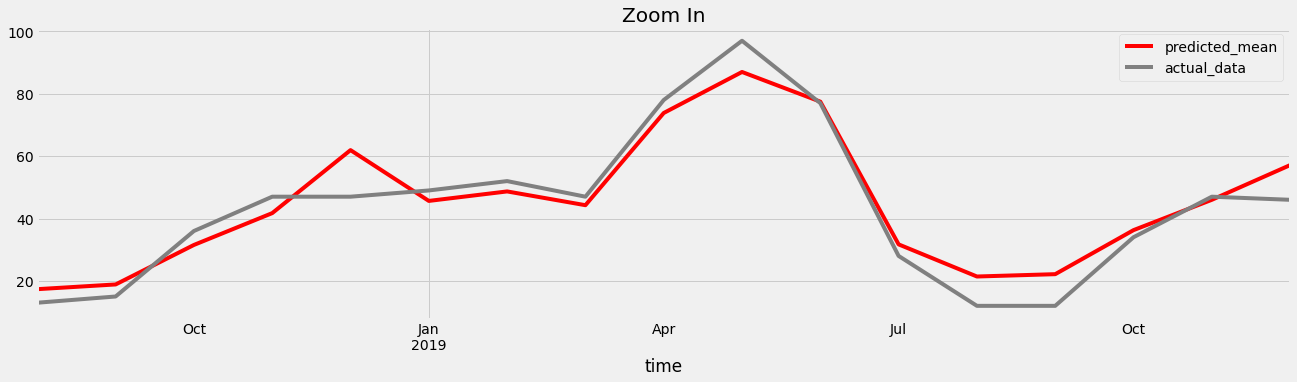

In [8]:
predictions_arima.plot(figsize=(20,5),color='red',label = 'predicted_value')
NBA[151:168].plot(figsize=(20,5),color='gray',label = 'actual_data')
plt.legend()
plt.title('Zoom In')
plt.show()

In [9]:
from sklearn.metrics import mean_squared_error

In [10]:
testing_error = mean_squared_error(testing,predictions_arima)
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("ARIMA Performance")
print(f"  Training is from {str(training.index[0])} to {str(training.index[-1])}, with {len(training)} data points")
print(f"  Testing is from {str(testing.index[0])} to {str(testing.index[-1])}, with {len(testing)} data points")
print(f"  MSE of testing set is: {testing_error}")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")

---------------------------------------------------------------
---------------------------------------------------------------
ARIMA Performance
  Training is from 2006-01 to 2018-07, with 151 data points
  Testing is from 2018-08 to 2019-12, with 17 data points
  MSE of testing set is: 46.31352816343268
---------------------------------------------------------------
---------------------------------------------------------------


# Gaussian Process Regression

* Model Identification: Observe the times series to determine the kernel components
* Observation: In time series, there is a gradual increasing trend; a repeating pattern of periodicity within a year; a medium term irregularity
* Decision:
    1. An RBF component could explain the gradual increasing trend, and a relatively large length scale could enforce smoothness
    2. An ExpiSineSquared component could explain the periodicity. In order to allow decaying away from exact periodicity, the product with an RBF kernel is taken. The parameters are chosen by experimenting with data
    3. An RationalQuadratic component could explain the smaller, medium term irregularities
    4. A WhiteKernel "noise" term could explain the correlated noise

In [11]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ExpSineSquared, RBF, ConstantKernel as C,DotProduct, WhiteKernel,RationalQuadratic

In [12]:
training_index = np.arange(151).reshape(-1,1)
testing_index = np.arange(151,168).reshape(-1,1)
training_Y = training.values.reshape(-1,1)

In [13]:
kernel = RBF(length_scale=30) + \
         2.0*RBF(length_scale=100) * ExpSineSquared(length_scale=20, periodicity=12)+ \
         RationalQuadratic(alpha=20,length_scale=1) + \
         WhiteKernel(noise_level=1)
gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=100,normalize_y=True)
gpr.fit(training_index,training_Y)

GaussianProcessRegressor(kernel=RBF(length_scale=30) + 1.41**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=20, periodicity=12) + RationalQuadratic(alpha=20, length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=100, normalize_y=True)

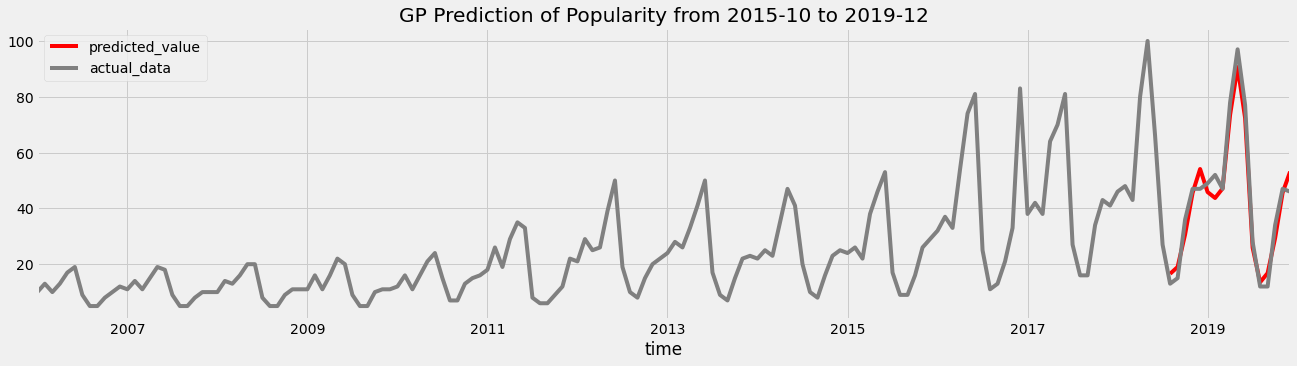

In [14]:
predictions_gp = pd.Series(gpr.predict(testing_index).ravel())
predictions_gp.index = NBA.index[151:168]
predictions_gp.plot(figsize=(20,5),color='red',label = 'predicted_value')
NBA.plot(figsize=(20,5),color='gray',label = 'actual_data')
plt.title('GP Prediction of Popularity from 2015-10 to 2019-12')
plt.legend()
plt.show()

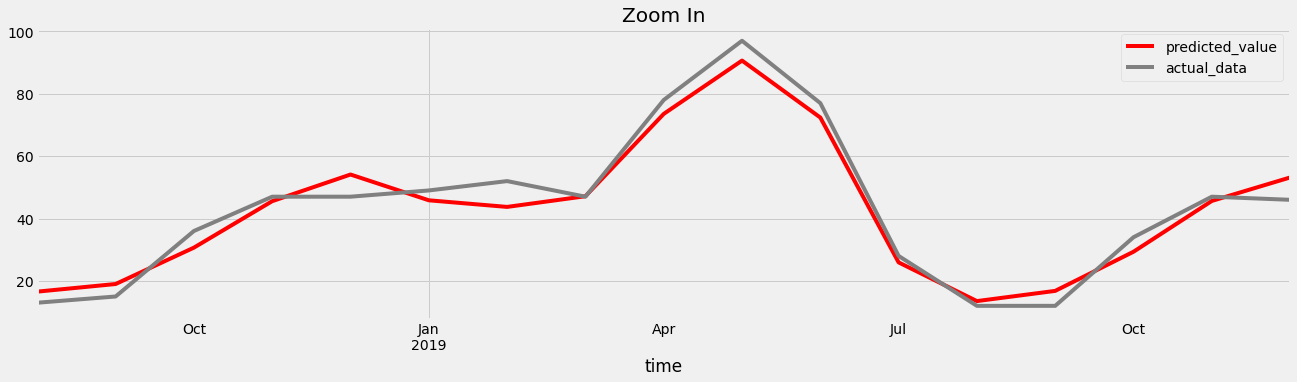

In [15]:
predictions_gp.plot(figsize=(20,5),color='red',label = 'predicted_value')
NBA[151:168].plot(figsize=(20,5),color='gray',label = 'actual_data')
plt.legend()
plt.title('Zoom In')
plt.show()

In [16]:
testing_error = mean_squared_error(testing,predictions_gp)
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")
print("GP Performance")
print(f"  Training is from {str(training.index[0])} to {str(training.index[-1])}, with {len(training)} data points")
print(f"  Testing is from {str(testing.index[0])} to {str(testing.index[-1])}, with {len(testing)} data points")
print(f"  MSE of testing set is: {testing_error}")
print("---------------------------------------------------------------")
print("---------------------------------------------------------------")

---------------------------------------------------------------
---------------------------------------------------------------
GP Performance
  Training is from 2006-01 to 2018-07, with 151 data points
  Testing is from 2018-08 to 2019-12, with 17 data points
  MSE of testing set is: 22.01541462891438
---------------------------------------------------------------
---------------------------------------------------------------


# Conclusion

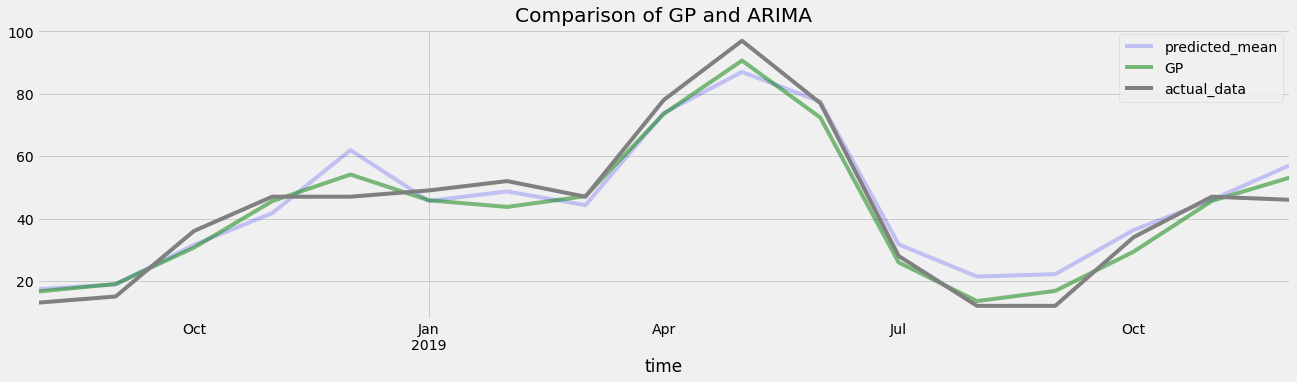

In [18]:
predictions_arima.plot(figsize=(20,5),color='blue',alpha = 0.2,label = 'ARIMA')
predictions_gp.plot(figsize=(20,5),color='green',alpha = 0.5,label = 'GP')
NBA_testing = NBA[151:168]
NBA_testing.plot(figsize=(20,5),color='gray',label = 'actual_data')
plt.legend()
plt.title('Comparison of GP and ARIMA')
plt.show()

The results show that ARIMA's mse is about 46 on the testing set, while the GP's mse is about 22 on the testing set. GP perform better in prediction into the future. However, the runtime of the fitting process of GP is much slower than that of ARIMA.